Модель процесса обслуживания покупателей на кассах в магазине

In [35]:
# # -*- coding: utf-8 -*-
# # Импорт среды SimPy
# import simpy
# # Для генерации случайных чисел
# import random
# # В этой модели полагаем, что единица модельного времени
# # соответствует 1 секунде реального времени
# # Длительность покупки\получения услуги
# MAX_SERVICE_DURATION = 20 * 60
# # т.е. максимальная длительность обслуживания 20 мин
# MODE_SERVICE_DURATION = 7 * 60
# # индивидуальное время обслуживания треугольно распределенной
# # случайной величине на интервале [30, 20*60, 7*60]

# # макс.интервал до появления нового покупателя
# ARRIV_INTER = 3 * 60
# # время появления нового покупателя равномерно распределенная
# # случайная величина на интервале [0, 4 * 60]

# # Время работы магазина (10 часов)
# # После 10 часов работы магазин закрывают и обслуживают только оставшихся, 
# # если таковые имеются
# CONSUMER_TIME = 3600 * 10

# # ------------ параметры для статистики --------
# quelog = [] # журнал длины очереди
# tservlog =[] # журнал пребывания в системе


# -*- coding: utf-8 -*-
# Core imports
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np

# Simulation configurations (ALL TIMES IN SECONDS)
configurations = {
    'config1': {'cashiers': 2, 'arrival_interval': 180, 'max_service': 1200, 'mode_service': 420},
    'config2': {'cashiers': 4, 'arrival_interval': 180, 'max_service': 1200, 'mode_service': 420},
    'config3': {'cashiers': 6, 'arrival_interval': 180, 'max_service': 1200, 'mode_service': 420},
    'config4': {'cashiers': 6, 'arrival_interval': 90, 'max_service': 1200, 'mode_service': 420}
}

CONSUMER_TIME = 3600 * 10  # 10 hours simulation
quelog = []  # Queue length tracker
tservlog = []  # Service time tracker
total_served = 0  # Successful service counter
total_left = 0  # Abandoned customers counter

Класс описания поведения клиента

In [36]:
# # Класс - покупатель магазина - логический блок-процессор
# class Client(object):
#     def __init__(self, env, res, name='client'):
#         self.name = name  # Имя покупателя, чтобы их различать
#         self.env = env  # Среда моделирования
#         self.res = res  # используемый при моделировании ресурс,- касса

#     def run(self):
#         # ссылка на глобальные счетчики статистики
#         # для графиков после моделирования
#         global  quelog, tservlog, rescnt
#         # человек пришел и сразу встал в очередь: она увеличилась на 1
#         # Запомним время, чтобы посчитать потом время пребывания в очереди
#         timeq = self.env.now
#         print(f"Привет! Это {self.name} и я прибыл в магазин в {timeq} (сек)")
#         # Запрос свободной кассы
#         with self.res.request() as req:
#             # Нет свободной кассы? в очередь
#             yield req
#             # Свободная касса появилась!
#             # Человек поступает на обслуживание и очередь уменьшается на 1
#             # запомним текущую длину очереди
#             # запомним текущее время события
#             # переменная (wait-timeq) - время, проведенное в очереди
#             wait = self.env.now
#             quelog.append((wait, len(self.res.queue)))
#             # время обслуживания - случайное число, генерируем его
#             serving_duration = int(random.triangular(30, MAX_SERVICE_DURATION, MODE_SERVICE_DURATION))
#             # обслуживаемся в кассе!
#             yield self.env.timeout(serving_duration)
#             # Обслужились и освободили кассу
#             print(f"Я {self.name}, обслуживался {serving_duration} сек, ждал в очереди {wait-timeq} сек")
#             # Запомним время проведенное в магазине
#             # Запомним текущее время события - клиент ушел
#             tservlog.append((self.env.now, self.env.now-timeq))
#             print(f"Меня обслужили и сейчас (время={self.env.now}) я ушёл.")


class Client(object):
    def __init__(self, env, res, name='client', max_wait_time=None):
        self.name = name
        self.env = env
        self.res = res
        self.max_wait_time = max_wait_time
        self.served = False

    def run(self):
        global quelog, tservlog, total_served, total_left
        timeq = self.env.now
        
        # [TASK 2 IMPLEMENTATION] - Different behavior based on wait time
        if self.max_wait_time:
            # Client with patience limit
            req = self.res.request()
            result = yield req | self.env.timeout(self.max_wait_time)
            
            if req in result:
                # Got service before timeout
                wait = self.env.now
                quelog.append((wait, len(self.res.queue)))
                serving_duration = int(random.triangular(30, self.res.max_service, self.res.mode_service))
                yield self.env.timeout(serving_duration)
                self.served = True
                tservlog.append((self.env.now, self.env.now-timeq))
                total_served += 1
            else:
                # Left due to timeout
                req.cancel()
                total_left += 1
        else:
            # Original patient client
            with self.res.request() as req:
                yield req
                wait = self.env.now
                quelog.append((wait, len(self.res.queue)))
                serving_duration = int(random.triangular(30, self.res.max_service, self.res.mode_service))
                yield self.env.timeout(serving_duration)
                self.served = True
                tservlog.append((self.env.now, self.env.now-timeq))
                total_served += 1

Подготовка модельной среды и объявление функции-генератора клиентов

In [37]:
# # Инициализация среды моделирования
# env = simpy.Environment()

# # Ресурс обслуживания; в данном случае - capacity - число касс,
# # которые обслуживают покупателей
# cashier = simpy.Resource(env, capacity=6)

# # Источник покупателей предполагает, что покупатели приходят 
# # в течение 10 часов от начала работы магазина
# def source_men(env):
#     ind = 0
#     while env.now < (CONSUMER_TIME - ARRIV_INTER): # покупатели приходят 10 часов
#         ind += 1
#         yield env.timeout(random.randint(0, ARRIV_INTER))
#         man = Client(env, cashier, name=f'клиент{ind}')
#         env.process(man.run())

def source_men(env, config, max_wait_time=None):
    ind = 0
    while env.now < (CONSUMER_TIME - config['arrival_interval']):
        ind += 1
        yield env.timeout(random.randint(0, int(config['arrival_interval'])))  # Fixed: added int() conversion
        man = Client(env, cashier, name=f'клиент{ind}', max_wait_time=max_wait_time)
        env.process(man.run())

Настройка параметров модели и запуск прогона

In [38]:
# # инициализация датчика случайных чисел
# #random.seed(13971)
# # инициализация журналов статистики
# quelog,tservlog = [],[]

# # Добавляем процесс прихода покупателей в модель
# env.process(source_men(env))

# # Запускаем процесс моделирования, полагая, что 
# # 1 ед.модельного времени = 1 секунда реального времени;
# # процесс моделирования составляет 12 часов; 
# env.run(until=12 * 60 * 60)

def run_simulation(config, max_wait_time=None):
    global quelog, tservlog, total_served, total_left, cashier
    
    quelog, tservlog = [], []
    total_served = 0
    total_left = 0
    
    env = simpy.Environment()
    cashier = simpy.Resource(env, capacity=config['cashiers'])
    cashier.max_service = config['max_service']
    cashier.mode_service = config['mode_service']
    
    env.process(source_men(env, config, max_wait_time))
    env.run(until=12 * 60 * 60)
    
    max_queue = max([q[1] for q in quelog]) if quelog else 0
    times_in_system = [t[1] for t in tservlog]
    under_5min = len([t for t in times_in_system if t <= 300]) / len(times_in_system) if times_in_system else 0
    
    return {
        'total_served': total_served,
        'total_left': total_left,
        'max_queue': max_queue,
        'under_5min': under_5min,
        'queue_data': quelog,
        'time_data': tservlog
    }

Подготовка статистики и вывод графиков


Running config1...

Running config2...

Running config3...

Running config4...


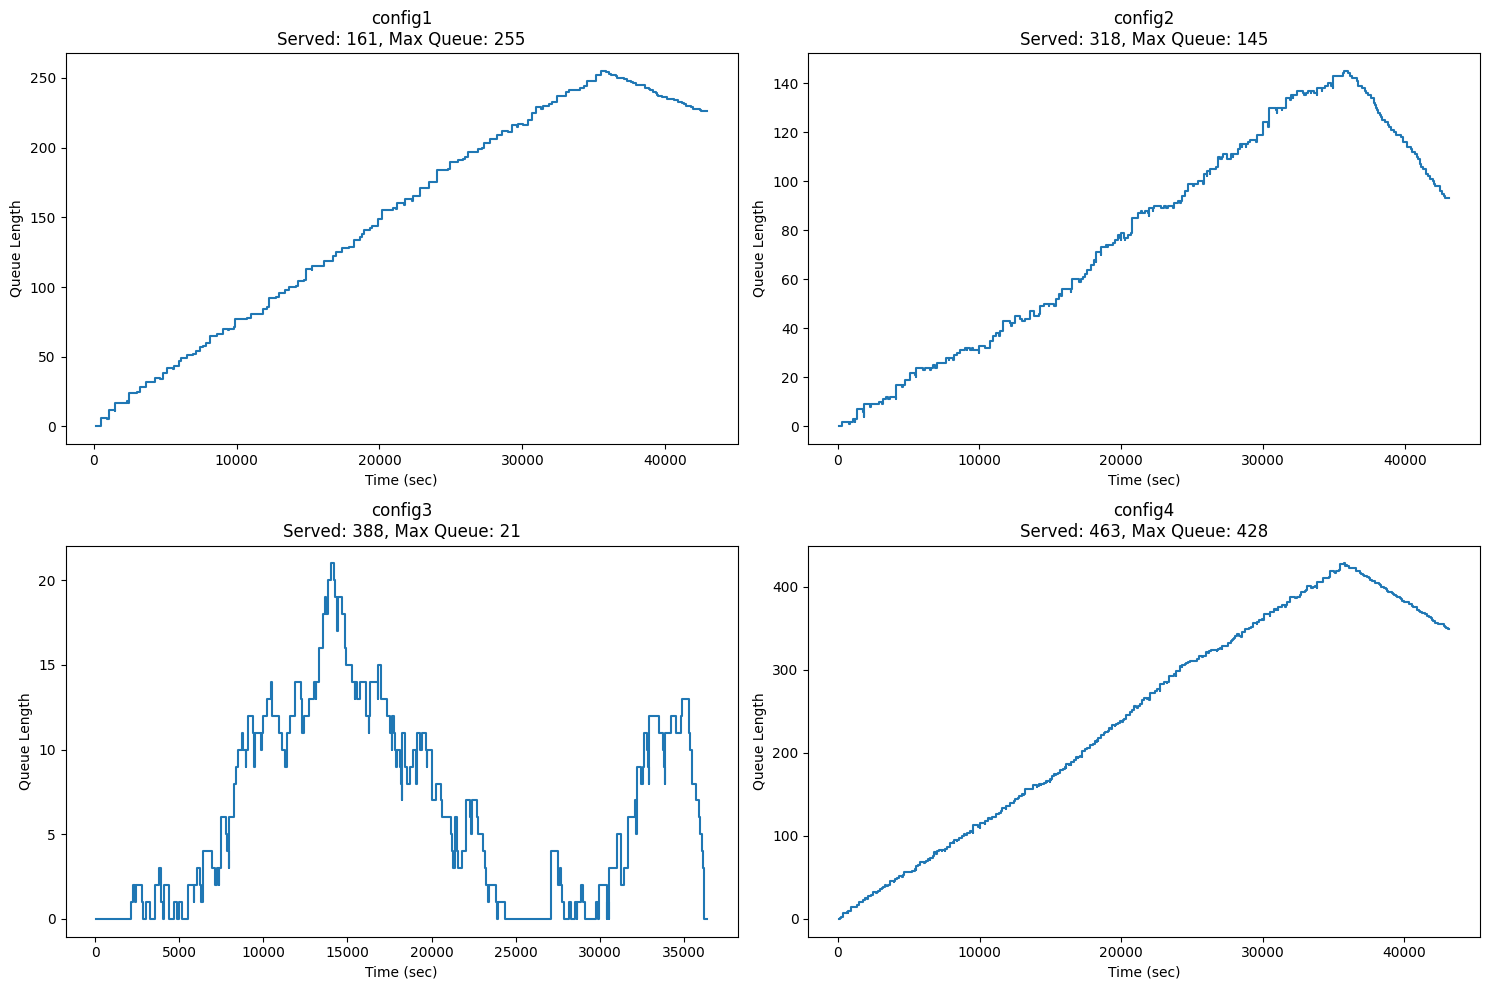

In [39]:
# try: 
#     import matplotlib.pyplot as plt
#     fig, ax = plt.subplots()
#     # График длины очереди quelog
#     ax.step([p[0] for p in quelog], [p[1] for p in quelog], label='очередь')
#     ax.set_title('Клиентов в очереди')
#     ax.set_xlabel('Время, сек')
#     ax.set_ylabel('длина очереди, #')
#     fig, bx = plt.subplots()
#     # График времени пребывания в системе tservlog
#     bx.scatter([p[0] for p in tservlog], [p[1] for p in tservlog], c='g', marker='x')
#     bx.set_title(f'Время пребывания_')
#     bx.set_xlabel('Время, сек')
#     bx.set_ylabel('Пребывание, сек')
#     plt.show()
# # --------------------------------------------------------------------------------------
# except ImportError:
#     print('without matplotlib!')



# results = {}
# for config_name, config in configurations.items():
#     print(f"\nЗапуск конфигурации {config_name}...")
#     results[config_name] = run_simulation(config)

# plt.figure(figsize=(15, 10))
# for i, (config_name, result) in enumerate(results.items(), 1):
#     plt.subplot(2, 2, i)
#     if result['queue_data']:
#         plt.step([p[0] for p in result['queue_data']], [p[1] for p in result['queue_data']])
#     plt.title(f"{config_name}\nОбслужено: {result['total_served']}, Макс.очередь: {result['max_queue']}")
#     plt.xlabel('Время, сек')
#     plt.ylabel('Длина очереди')
# plt.tight_layout()
# plt.show()

# print("\nСравнение config4 с разными типами клиентов...")
# config4 = configurations['config4']

# result_no_limit = run_simulation(config4)
# print(f"Без ограничения времени: обслужено {result_no_limit['total_served']}, доля до 5 мин: {result_no_limit['under_5min']:.1%}")

# result_with_limit = run_simulation(config4, max_wait_time=300)  # 5 minutes in seconds
# print(f"С ограничением времени: обслужено {result_with_limit['total_served']}, ушли {result_with_limit['total_left']}, доля до 5 мин: {result_with_limit['under_5min']:.1%}")

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# if result_no_limit['queue_data']:
#     plt.step([p[0] for p in result_no_limit['queue_data']], [p[1] for p in result_no_limit['queue_data']])
# plt.title(f"Без ограничения\nОбслужено: {result_no_limit['total_served']}\nДоля ≤5мин: {result_no_limit['under_5min']:.1%}")
# plt.xlabel('Время, сек')
# plt.ylabel('Длина очереди')

# plt.subplot(1, 2, 2)
# if result_with_limit['queue_data']:
#     plt.step([p[0] for p in result_with_limit['queue_data']], [p[1] for p in result_with_limit['queue_data']])
# plt.title(f"С ограничением\nОбслужено: {result_with_limit['total_served']}\nУшли: {result_with_limit['total_left']}\nДоля ≤5мин: {result_with_limit['under_5min']:.1%}")
# plt.xlabel('Время, сек')
# plt.ylabel('Длина очереди')

# plt.tight_layout()
# plt.show()


# ======================
# TASK 1 IMPLEMENTATION
# ======================
results = {}
for config_name, config in configurations.items():
    print(f"\nRunning {config_name}...")
    results[config_name] = run_simulation(config)

# Prepare figure for Task 1
plt.figure(figsize=(15, 10))
for i, (config_name, result) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    if result['queue_data']:
        plt.step([p[0] for p in result['queue_data']], [p[1] for p in result['queue_data']])
    plt.title(f"{config_name}\nServed: {result['total_served']}, Max Queue: {result['max_queue']}")
    plt.xlabel('Time (sec)')
    plt.ylabel('Queue Length')
plt.tight_layout()
plt.show()

In [40]:
# ======================
# TASK 1 STATISTICS
# ======================
print("\n=== Configuration Comparison ===")
for config_name, result in results.items():
    print(f"{config_name}:")
    print(f"  • Customers served: {result['total_served']}")
    print(f"  • Max queue length: {result['max_queue']}")
    print(f"  • % served ≤5min: {result['under_5min']:.1%}\n")



=== Configuration Comparison ===
config1:
  • Customers served: 161
  • Max queue length: 255
  • % served ≤5min: 0.0%

config2:
  • Customers served: 318
  • Max queue length: 145
  • % served ≤5min: 0.0%

config3:
  • Customers served: 388
  • Max queue length: 21
  • % served ≤5min: 2.6%

config4:
  • Customers served: 463
  • Max queue length: 428
  • % served ≤5min: 0.4%



In [41]:
# ======================
# TASK 2 IMPLEMENTATION
# ======================
print("\n=== Task 2: Config4 Comparison ===")
config4 = configurations['config4']

# Run without wait limit
print("\nRunning config4 WITHOUT wait limit...")
result_no_limit = run_simulation(config4)

# Run with 5min wait limit
print("\nRunning config4 WITH 5min wait limit...")
result_with_limit = run_simulation(config4, max_wait_time=300)

# Prepare comparison data
comparison_data = [
    ("No Wait Limit", result_no_limit),
    ("5min Wait Limit", result_with_limit)
]


=== Task 2: Config4 Comparison ===

Running config4 WITHOUT wait limit...

Running config4 WITH 5min wait limit...


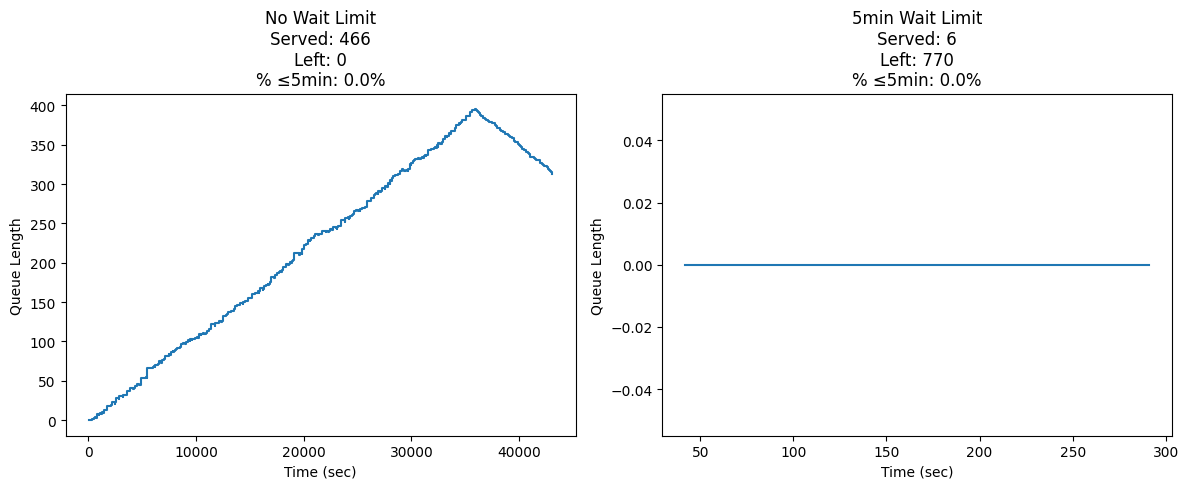

In [42]:
# ======================
# TASK 2 VISUALIZATION
# ======================
plt.figure(figsize=(12, 5))

for i, (label, result) in enumerate(comparison_data, 1):
    plt.subplot(1, 2, i)
    if result['queue_data']:
        plt.step([p[0] for p in result['queue_data']], [p[1] for p in result['queue_data']])
    plt.title(f"{label}\nServed: {result['total_served']}\n"
              f"Left: {result.get('total_left', 0)}\n"
              f"% ≤5min: {result['under_5min']:.1%}")
    plt.xlabel('Time (sec)')
    plt.ylabel('Queue Length')

plt.tight_layout()
plt.show()

In [43]:
# ======================
# TASK 2 ANALYSIS
# ======================
print("\n=== Detailed Performance ===")
for label, result in comparison_data:
    print(f"\n{label}:")
    print(f"Total served: {result['total_served']}")
    if 'total_left' in result:
        print(f"Abandoned: {result['total_left']} ({result['total_left']/(result['total_served']+result['total_left']):.1%})")
    print(f"Service ≤5min: {result['under_5min']:.1%}")
    print(f"Peak queue: {result['max_queue']}")


=== Detailed Performance ===

No Wait Limit:
Total served: 466
Abandoned: 0 (0.0%)
Service ≤5min: 0.0%
Peak queue: 395

5min Wait Limit:
Total served: 6
Abandoned: 770 (99.2%)
Service ≤5min: 0.0%
Peak queue: 0
